# Embedding extractor

Note my_custom_dataset.py currently uses my data format. It will need switching up to jsut load new audio isntead, maybe cut this up etc. Could turn to open soundscape for this?

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

# my_custom_dataset.py must be in the same directory as this script
from my_custom_dataset import CTDataset

Create a quick config, maybe make an actual file eventually

In [7]:
starting_weights = "/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/logs/exman-train.py/runs/baseline/checkpoint-5100.pth.tar"

cfg = {'num_classes': 2, 'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_australia'} #######################

### Load model

In [14]:
# Your model definition
class SimClrPytorchResNet50(nn.Module):
    def __init__(self, num_classes):
        super(SimClrPytorchResNet50, self).__init__()
        self.convnet = models.resnet50(pretrained=False)
        last_layer = self.convnet.fc
        in_features = last_layer.in_features
        self.convnet.fc = nn.Identity()
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        '''
            Forward pass. Here, we define how to apply our model. It's basically
            applying our modified ResNet-18 on the input tensor ("x") and then
            apply the final classifier layer on the ResNet-18 output to get our
            num_classes prediction.
        '''
        # x.size(): [B x 3 x W x H]
        features = self.convnet(x)    # features.size(): [B x 512 x W x H]
        prediction = self.classifier(features)  # prediction.size(): [B x num_classes]

        return prediction

# Your function to load pretrained weights
def load_pretrained_weights(cfg, model):
    custom_weights = cfg['starting_weights']
    state = torch.load(open(custom_weights, 'rb'), map_location='cpu')

    if 'state_dict' in state.keys():
        pretrained_dict = state['state_dict']
    else:
        pretrained_dict = state['model']

    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and k not in ['classifier.weight', 'classifier.bias']}
    log = model.load_state_dict(pretrained_dict, strict=False)
    assert log.missing_keys == ['classifier.weight', 'classifier.bias']
    return model

In [15]:
# Initialize your model
model_instance = SimClrPytorchResNet50(cfg['num_classes'])

# Load the pretrained weights
model_instance = load_pretrained_weights(cfg, model_instance)

In [4]:
# not using it currently, unsure if works
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            images = images.to(device)
            embeddings = model.convnet(images)  # Get embeddings from the convnet
            all_embeddings.append(embeddings.cpu().numpy())
            
    return np.concatenate(all_embeddings)

### Create dataloader

In [20]:
from torch.utils.data import DataLoader, SubsetRandomSampler

In [29]:
dataset = CTDataset(cfg, split='test_data', transform=True) # ditch split at some point
sample_loader = DataLoader(dataset, batch_size=1, shuffle=True) 

In [30]:
def extract_single_embedding(model, single_batch, device):
    model.eval()
    with torch.no_grad():
        images = single_batch  # Assuming the DataLoader returns only spectrogram, not labels
        images = images.to(device)
        embedding = model.convnet(images)  # Get embeddings from the convnet
        return embedding.cpu().numpy()

def extract_multiple_embeddings(model, data_batch, device):
    model.eval()
    
    # Forward pass to get embeddings
    with torch.no_grad():
        # Assuming that your model has a method or attribute `convnet` that you want to get embeddings from
        embeddings = model.convnet(data)
        
    return embeddings

In [31]:
# Initialize iterator and list to hold embeddings
sample_iterator = iter(sample_loader)
all_embeddings = []

# Function to get the next batch of embeddings
def get_next_batch_embeddings(sample_iterator, model, device):
    batch = next(sample_iterator)
    return extract_multiple_embeddings(model, batch, device)  # Assuming this function is able to handle batches

# Get 10 embeddings
for _ in range(10):  # Change the range to get more batches
    batch_embeddings = get_next_batch_embeddings(sample_iterator, model_instance, device)
    all_embeddings.append(batch_embeddings)

print(f'Looking at {len(all_embeddings)} samples')

# Convert list of tensors to a single tensor
all_embeddings = torch.cat(all_embeddings, dim=0)

# Flatten the tensor to 1D for histogram plotting
all_embedding_values = all_embeddings.flatten().cpu().numpy()

# Plot histogram
plt.figure(figsize=(20, 5))
bin_size = 0.05
bin_edges = np.arange(start=min(all_embedding_values), stop=max(all_embedding_values) + bin_size, step=bin_size)

plt.hist(all_embedding_values, bins=bin_edges, alpha=0.7, edgecolor='black')
plt.title('Histogram of Embedding Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

TypeError: conv2d() received an invalid combination of arguments - got (module, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!module!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!module!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


### Plot the histogram of one sample

We set split = test_data to make sure its from the test_data

In [20]:
# Make sure to move your model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_instance.to(device)

# Fetch a single batch from your DataLoader
single_batch = next(iter(sample_loader))

# Extract embeddings for this single batch
single_embedding = extract_single_embedding(model_instance, single_batch, device)

print(f"Single embedding shape: {single_embedding.shape}")


Single embedding shape: (1, 2048)


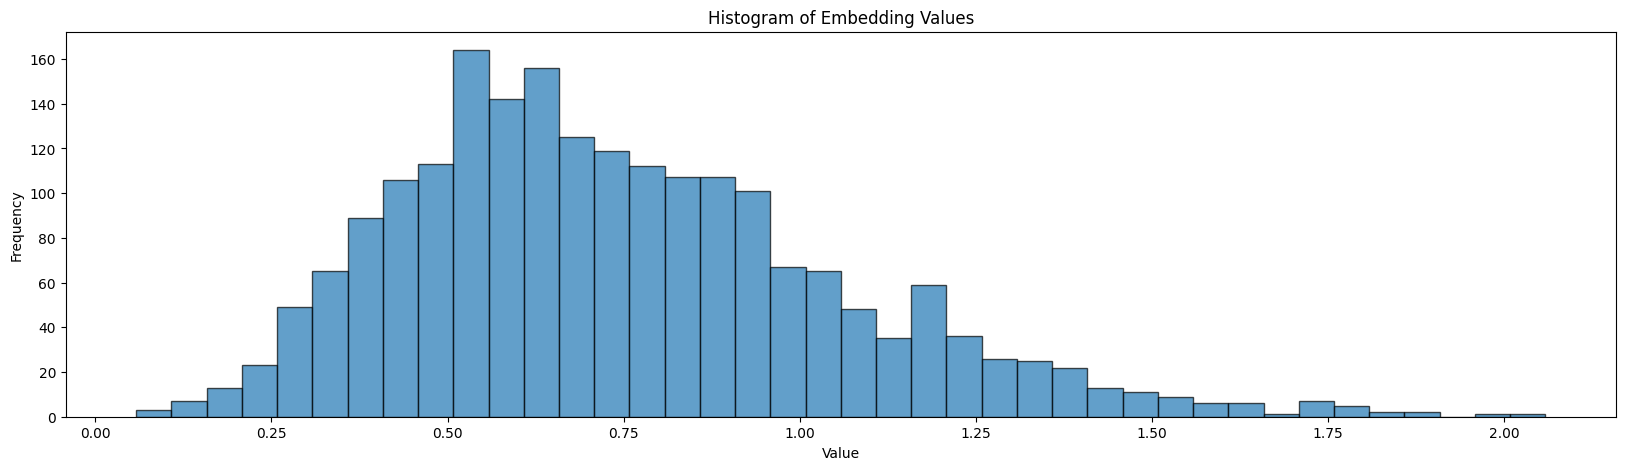

In [22]:
import matplotlib.pyplot as plt

# Assuming single_embedding is your obtained embedding
embedding_values = single_embedding.flatten()  # Flatten to 1D if not already

plt.figure(figsize=(20, 5))  # Set the figure size for better visibility

bin_size = 0.05
bin_edges = np.arange(start=min(embedding_values), stop=max(embedding_values) + bin_size, step=bin_size)

plt.hist(embedding_values, bins=bin_edges, alpha=0.7, edgecolor='black')
plt.title('Histogram of Embedding Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()


### Test embedding extractor 
Uses randomly generated images (3,224,224)

In [27]:
import torch
import torch.utils.data as data
import numpy as np

# Create random tensors to simulate your image data
num_samples = 100  # Number of random samples
image_shape = (3, 224, 224)  # Shape of each "image"

random_data = torch.randn(num_samples, *image_shape)
random_labels = torch.randint(0, 2, (num_samples,))  # Random labels assuming binary classification

# Create a DataLoader
dataset = data.TensorDataset(random_data, random_labels)
dataloader = data.DataLoader(dataset, batch_size=16, shuffle=True)

# Extract embeddings using your function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Make sure to move your model to the device
model_instance.to(device)

# Assuming extract_embeddings is the function you used earlier
all_embeddings = extract_multiple_embeddings(model_instance, dataloader, device)

print(f"All embeddings shape: {all_embeddings.shape}")


NameError: name 'extract_multiple_embeddings' is not defined

# PCA stuff

In [85]:
starting_weights = "/home/ben/reef-audio-representation-learning/code/simclr-pytorch-reefs/logs/exman-train.py/runs/baseline/checkpoint-5100.pth.tar"

cfg = {'num_classes': 2, 'starting_weights': starting_weights, 'finetune': False,
       'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', 
       'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
       'test_dataset': 'test_australia'} #######################

In [84]:
from my_custom_dataset_eval import CTDataset_train, CTDataset_test

split = 'test_data'
transform = False
train_percent = 0.8

#dataset = CTDataset_train(cfg, split=split, transform=transform, train_percent=train_percent)
dataset_instance = CTDataset_train(cfg, split=split, transform=transform, train_percent=train_percent)

In [86]:
def get_dataloader(cfg, split, transform, train_percent, batch_size, shuffle, num_workers):
    
    dataset = CTDataset_train(cfg, split, transform, train_percent)

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )

    return dataloader

sample_loader = get_dataloader(cfg, split, transform=False, train_percent = train_percent, batch_size=64, shuffle=False, num_workers=4) 


In [87]:
def extract_multiple_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    labels = []
    
    with torch.no_grad():
        for i, (audio, classes) in enumerate(dataloader):
            #print(labels)
            audio = audio.to(device)
            embeddings = model.convnet(audio)  # Get embeddings from the convnet
            all_embeddings.extend(embeddings.cpu().numpy())
            labels.extend(classes.numpy())
            
    return all_embeddings, labels

embeddings, labels = extract_multiple_embeddings(model_instance, sample_loader, device)

ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 ERROR: Unexpected segmentation fault encountered in worker.
 

RuntimeError: DataLoader worker (pid(s) 3446723, 3446786, 3446912) exited unexpectedly

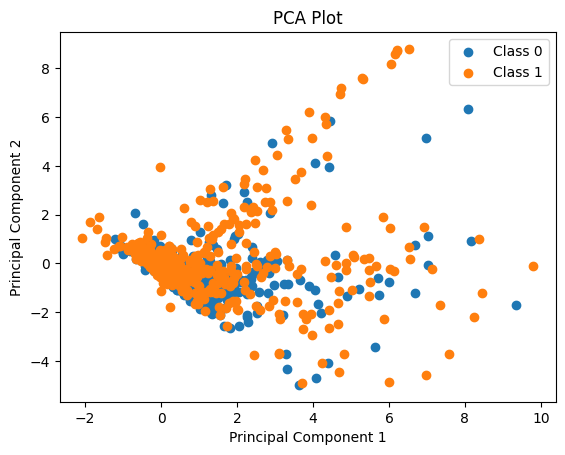

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Convert embeddings to a NumPy array for easier manipulation
embeddings = np.array(embeddings)

# Initialize PCA and the X vector for dimensionality reduction
pca = PCA(n_components=2)

# Fit and transform the embeddings to get new 2D representations
embeddings_pca = pca.fit_transform(embeddings)

# Create a scatter plot
classes = np.unique(labels)  # Extract unique labels to identify distinct classes
for class_label in classes:
    idx = np.where(np.array(labels) == class_label)  # Get index where class label is found
    plt.scatter(embeddings_pca[idx, 0], embeddings_pca[idx, 1], label=f"Class {class_label}")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="upper right")
plt.title("PCA Plot")
plt.show()